In [1]:
import os
import imp
import numpy as np
import pandas as pd
import functions as utils
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from functools import partial
from concurrent.futures import ProcessPoolExecutor, Executor, as_completed

In [101]:
def read_data(path, filename):
    print(f'reading file = {os.path.join(path, filename)}')
    data = pd.read_csv(os.path.join(path, filename))
    data = data.rename(columns={'Unnamed: 0':'Id'})
    print(f'data shape = {data.shape}')
    types_info = pd.DataFrame(data.dtypes.value_counts(), columns=['columns_count'])
    print('types info about df columns: ')
    print(types_info)
    return data

In [102]:
# ls -la -h Datasets/GiveMeSomeCredit/

In [180]:
train_data = read_data(path='Datasets/GiveMeSomeCredit/', filename='cs-training.csv')
# test_data = read_data(path='Datasets/GiveMeSomeCredit/', filename='cs-test.csv')
# descript = pd.read_excel("Datasets/GiveMeSomeCredit/Data Dictionary.xls")
# sample_data = pd.read_csv("Datasets/GiveMeSomeCredit/sampleEntry.csv")

reading file = Datasets/GiveMeSomeCredit/cs-training.csv
data shape = (150000, 12)
types info about df columns: 
         columns_count
int64                8
float64              4


In [184]:
revolve_thresh = round(np.quantile(train_data.RevolvingUtilizationOfUnsecuredLines.values, q=[0.99])[0], 3)
# debtratio_thresh = round(np.quantile(train_data.DebtRatio.values, q=[0.9])[0], 3)
debtratio_thresh = 2.1
revolve_thresh

train_data = train_data[(train_data.RevolvingUtilizationOfUnsecuredLines < revolve_thresh) & 
                        (train_data.DebtRatio < debtratio_thresh)
                       ]
train_data.shape

(116722, 12)

In [189]:
train_data.fillna(int(train_data.MonthlyIncome.mean()), inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [193]:
train_data.fillna(0, inplace=True)
# test_data.fillna(0, inplace=True)

#ставим колонку Id как индекс клиента
train_data.set_index('Id', inplace=True)
# test_data.set_index('Id', inplace=True)

#сохраняем метку класса
train_label = train_data['SeriousDlqin2yrs'].copy()
train_data.drop('SeriousDlqin2yrs', axis=1, inplace=True)
#удаляем колонку класса из тестовых данных, так как она не несет никакой информации
# test_data.drop('SeriousDlqin2yrs', axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [196]:
train_data['NumberOfDependents'] = train_data.NumberOfDependents.astype('int')
train_data['MonthlyIncome'] = train_data.MonthlyIncome.astype('int')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [197]:
train_data.shape#, test_data.shape

(116722, 10)

In [198]:
float_cols = train_data.select_dtypes('float').columns
train_data.loc[:, float_cols] = train_data.loc[:, float_cols].round(2)
# train_data.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [199]:
# float_cols = test_data.select_dtypes('float').columns
# test_data.loc[:, float_cols] = test_data.loc[:, float_cols].round(2)
# test_data.head()

In [200]:
transformed_train = utils.transform_to_description(train_data)
# transformed_test = transform_to_description(test_data)
# transformed_train.head(5)

In [201]:
transformed_train.shape#, transformed_test.shape

(116722, 10)

In [202]:
trainX, testX, trainY, testY = train_test_split(transformed_train, train_label, test_size=0.4)

In [203]:
valX, testX, valY, testY = train_test_split(testX, testY, test_size=0.5)

In [204]:
print(trainX.shape, valX.shape, testX.shape)
print(trainY.shape, valY.shape, testY.shape)

(70033, 10) (23344, 10) (23345, 10)
(70033,) (23344,) (23345,)


In [205]:
trainY.value_counts(normalize=True)

0    0.937001
1    0.062999
Name: SeriousDlqin2yrs, dtype: float64

In [206]:
valY.value_counts(normalize=True)

0    0.936943
1    0.063057
Name: SeriousDlqin2yrs, dtype: float64

In [207]:
testY.value_counts(normalize=True)

0    0.935961
1    0.064039
Name: SeriousDlqin2yrs, dtype: float64

**Алгоритм из работы Алексея(QBCA)**

In [14]:
# alpha = 0.005
# sample_ratio = 0.01
# num_iters = 100
# N_neg = train_label.value_counts().reset_index().iloc[0, 1]
# N_pos = train_label.value_counts().reset_index().iloc[1, 1]
# N_neg, N_pos

**не обновляем индекс так как индекс - это id клиента, имеет значимую информацию**

In [208]:
# train_pos = transformed_train.loc[train_label[train_label == 1].index]
# train_neg = transformed_train.loc[train_label[train_label == 0].index]
train_pos = trainX.loc[trainY[trainY == 1].index]
train_neg = trainX.loc[trainY[trainY == 0].index]

train_neg.shape, train_pos.shape

((65621, 10), (4412, 10))

In [209]:
classes_ratio_pos = train_pos.shape[0] / train_neg.shape[0]
classes_ratio_neg = train_neg.shape[0] / train_pos.shape[0]
classes_ratio_pos, classes_ratio_neg

(0.06723457429786196, 14.873300090661832)

**Берем выборку заемов, для начального тестирования работоспособности**

In [87]:
train_pos = train_pos.sample(n=1000, replace=False)
train_neg = train_neg.sample(n=1000, replace=False)
train_pos.shape, train_neg.shape

((2000, 10), (2000, 10))

In [210]:
train_pos.shape, train_neg.shape

((4412, 10), (65621, 10))

In [342]:
test_sample = valX.sample(20)

### Mining step


    для положительного класса нас интересуют объекты отрицательного класса, 
    а для отрицательного - положительные
    Уже после определения объектов из другого класса, попадающие в признаковое представление семпла данных, будет приниматься решение
     о включение этого признакого представление в список гипотез представления(областей или интервальных представлений)
    

Что нужно посмотреть:

    1. Сравнение количества генерируемых гипотез в зависимости от критерия и области генерации выборки.
    (Возможно изобразить всего 4 варианта: старый подход - локальная или случайная выборка, новый подход - 
    локальная или случайная выборка)
    
    2. Сравнение генерируемых гипотез для старого и нового критерия в зависимости от ширины локальной области генерации
    (Возможно есть какая то оптимальная ширина окна)
    

To-do-list:
1. **классификации при разном включении признаков из исходного множества**

2. **Подумать о том, каким образом генерить гипотезы. То есть выбирать не случайно выборку из множества объектов,
    а какую-то локальную область. (Делать будем через расширение области объекта; более того, будем искать 
    оптимальное значение расширения локальной области) done !!!**

In [78]:
# d = utils.find_opt_local_area(obj=test_sample.iloc[0],
#                         train_data=train_pos,
#                         trainx_min=trainx_min,
#                         trainx_max=trainx_max,
#                         frac=0.15,
#                         num_iters=60
#                        )

# utils.generate_random_sample(train_data=train_pos, sample_size=10, d=d)

In [67]:
utils = imp.reload(utils)

In [275]:
def generate_hypothesis(iteration: int, obj: pd.Series, object_area: pd.Series, train_data: pd.DataFrame, 
                        other_data: pd.DataFrame, sample_size: int, classes_ratio: float,
                        hypothesis_criterion: str, sample_type:str, verbose: bool, alpha: float):
        
        print(f'iteration: {iteration}')
        
        if sample_type == 'local' and object_area is None:
            print(f'Cannot generate sample from local area. Got None as local object area param!')
            raise NotImplementedError('Wrong params for local sampling!')
    
        if sample_type == 'random' and object_area is not None:
            print(f'got misleading params values. Got sample_type = None and local object area is not None')
            return NotImplementedError('Wrong params for random sampling!')

        #generating random sample using sample strategy = {sample_type}
        sample = utils.generate_random_sample(train_data=train_data, sample_size=sample_size, d=object_area) 
        sample.append(obj)
        
        d = utils.get_similarity_sample_repr(sample)
        if verbose:
            print('got feature represantation for sample')
        
        d_other_objects = utils.is_included_in_repr(d, train_data=other_data)
        if d_other_objects is not None:
            print(f'got {d_other_objects.shape[0]} d_other_objects')
            print(f'thresh for hypothesis = {int(other_data.shape[0] * alpha)}')
    
        if d_other_objects is None:
            return d    
        
        result_hypothesis = utils.check_criterion(d=d, train_data=train_data, 
                                                  hypothesis_criterion=hypothesis_criterion, 
                                                  d_other_objects=d_other_objects,
                                                  other_data=other_data, alpha=alpha, 
                                                  classes_ratio=classes_ratio
                                                 )

        return result_hypothesis
        

        

def mining_step(test_obj: pd.Series, train_pos: pd.DataFrame, train_neg: pd.DataFrame, num_iters: int, 
                sample_ratio: float, alpha: float, hypothesis_criterion: str, sample_type: str,
                trainx_min: pd.Series, trainx_max:pd.Series, classes_ratio: float, 
                mining_type: str = 'pos', verbose : bool = False, n_jobs : int = 4):
    """
    hypothesis_criterion: 'contr_class', если используем базовый критерий, 
                                когда смотрится пересечение с противоположным классом(старый критерий отбора гипотез)
                           'both_classes', когда интересует пересечение по обоим классам(новый критерий отбора гипотез)
                           
    sample_type: 'random', если берем произвольную выборку интервальных представлений
                 'local', если берем произвольную выборку из локальной области
    
    returns list of hypothesises
    """
    
    if sample_type == 'local':
        #sampling
        print(f'start searching optimal local area')
        object_area = utils.find_opt_local_area(obj=test_obj,
                                                train_data=train_data,
                                                trainx_min=trainx_min,
                                                trainx_max=trainx_max,
                                                frac=0.15,
                                                num_iters=30
                                               )
    else:
        print(f'using random sample from train data')
        object_area = None
    
    train_data = train_pos if mining_type == 'pos' else train_neg
    other_data = train_neg if mining_type == 'pos' else train_pos
    sample_size = int(train_data.shape[0] * sample_ratio)
    print('start generating hypothesises')
    
    mining = partial(generate_hypothesis, 
                     obj=test_obj, 
                     object_area=object_area,
                     train_data=train_data, 
                     other_data=other_data, 
                     sample_size=sample_size,
                     classes_ratio=classes_ratio,
                     hypothesis_criterion=hypothesis_criterion,
                     sample_type=sample_type,
                     verbose=verbose,
                     alpha=alpha
                    )
    
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        hypothesises = executor.map(mining, range(num_iters))

    hypothesises = [res for res in hypothesises if res is not None]
    print(f'All hypothesises are generated!')
    return hypothesises

In [35]:
# for i, obj in test_sample.iterrows():
#     area = utils.find_opt_local_area(obj=obj, train_data=train_pos, num_iters=100)
#     if area is not None:
#         print('we found area')

# generate_local_sample(d=area, train_data=train_pos, sample_size=int(sample_ratio * train_pos.shape[0]))

# local_neg_objs = is_included_in_repr(d=area, train_data=train_neg)
# local_objs = is_included_in_repr(d=area, train_data=train_pos)
# len(local_objs), train_pos.shape, len(local_neg_objs)

# for i, obj in test_sample.iterrows():
#     sample = generate_local_sample(obj, train_data=train_pos, sample_size=3, num_iters=30)

# for i, obj in test_sample.iterrows():
#     print(type(obj))
# #     generate_local_sample(obj=obj, train_data=train_pos, sample_size=3)
#     generated = generate_local_area(obj)

# test_local_obj = transformed_train.sample(1)
# test_local_obj

# generated_obj = generate_local_area(test_local_obj)
# generated_obj

# generate_local_area(generated_obj)

In [23]:
train_pos.shape, train_neg.shape

((1000, 10), (1000, 10))

In [33]:
trainx_min = train_data.min()
trainx_max = train_data.max()

In [93]:
alpha = 0.001
sample_ratio = 0.002
num_iters = 1000

In [38]:
alpha_params = [0.000, 0.001, 0.002]#, 0.003, 0.004]
sample_ratio_params = [0.001, 0.002, 0.004]#, 0.006, 0.008]
alpha_params, sample_ratio_params

([0.0, 0.001, 0.002], [0.001, 0.002, 0.004])

In [ ]:
!!!Нужно построить график зависимости генерации гипотез от количества параметров
Нужно думаю что минимум 10 итераций

In [31]:
results_pos = {}
results_neg = {}
pos_hyps = []
neg_hyps = []

In [91]:
num_iters = 1000

**Исследование количества генерируемых гипотез в зависимости от параметров**

In [295]:
%%time
for i, obj in test_sample.iterrows():
    for alpha in alpha_params:
        for sample_ratio in sample_ratio_params:
            print(f'using params: alpha = {alpha}, sample_ratio = {sample_ratio}, num_iters = {num_iters}')
            
            pos_hyps = mining_step(test_obj=obj, train_pos=train_pos, train_neg=train_neg, 
                                   num_iters=num_iters,sample_ratio=sample_ratio, alpha = alpha,
                                   hypothesis_criterion='contr_class',sample_type='random',
                                   mining_type='pos', trainx_min=trainx_min, trainx_max=trainx_max,
                                   classes_ratio=classes_ratio_pos,
                                   verbose=False, n_jobs=4
                                  )
            pos_hyps_shape = pd.DataFrame(pos_hyps).shape[0] if len(pos_hyps) > 0 else 0
            results_pos[(alpha, sample_ratio, num_iters)] = pos_hyps_shape
#             print(f'start mining from neg objects')
            neg_hyps = mining_step(test_obj=obj, train_pos=train_pos, train_neg=train_neg,
                                   num_iters=num_iters, sample_ratio=sample_ratio, alpha = alpha, 
                                   hypothesis_criterion='contr_class', sample_type='random',
                                   mining_type='neg', trainx_min=trainx_min, trainx_max=trainx_max,
                                   classes_ratio=classes_ratio_neg,
                                   verbose=False, n_jobs=4
                                  )
            neg_hyps_shape = pd.DataFrame(neg_hyps).shape[0] if len(neg_hyps) > 0 else 0
            results_neg[(alpha, sample_ratio, num_iters)] = neg_hyps_shape

#### Такой способ не очень удобен, лучше разбивать не по такому большому ключу(кортеж параметров), а на список словарей со значениями

In [20]:
results_pos = {(0.0, 0.001, 1000): 1000,
 (0.0, 0.002, 1000): 608,
 (0.0, 0.004, 1000): 17,
 (0.001, 0.001, 1000): 1000,
 (0.001, 0.002, 1000): 740,
 (0.001, 0.004, 1000): 37,
 (0.002, 0.001, 1000): 1000,
 (0.002, 0.002, 1000): 790,
 (0.002, 0.004, 1000): 51}

In [28]:
values = {}
for key, val in results_pos.items():
        values[key[1]] = val
values

{0.001: 1000, 0.002: 790, 0.004: 51}

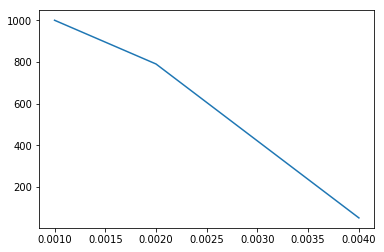

In [29]:
plt.plot(values.keys(), values.values())

In [43]:
results_neg

{(0.0, 0.001, 1000): 1000,
 (0.0, 0.002, 1000): 601,
 (0.0, 0.004, 1000): 11,
 (0.001, 0.001, 1000): 1000,
 (0.001, 0.002, 1000): 754,
 (0.001, 0.004, 1000): 46,
 (0.002, 0.001, 1000): 1000,
 (0.002, 0.002, 1000): 826,
 (0.002, 0.004, 1000): 57}

In [35]:
results_pos

{(0.0, 0.001, 100): 100,
 (0.0, 0.002, 100): 58,
 (0.001, 0.001, 100): 100,
 (0.001, 0.002, 100): 76}

In [36]:
results_neg

{(0.0, 0.001, 100): 100,
 (0.0, 0.002, 100): 66,
 (0.001, 0.001, 100): 100,
 (0.001, 0.002, 100): 75}

**Генерация гипотез для полож класса занимает 10 мин (с 4 процессами) c 3000 iterations**
**c 1000 iterations - 2 mins**

In [294]:
# %%time
# for i, obj in test_sample.iterrows():
#     print(type(obj))
#     print(f'start mining from pos objects')
#     pos_hyps = mining_step(test_obj=obj, train_pos=train_pos, train_neg=train_neg, 
#                            num_iters=num_iters,sample_ratio=sample_ratio, alpha = alpha,
#                            hypothesis_criterion='contr_class',
#                            sample_type='random',
#                            mining_type='pos',
#                            verbose=False, n_jobs=4
#                           )
    
#     print(f'start mining from neg objects')
#     neg_hyps = mining_step(test_obj=obj, train_pos=train_pos, train_neg=train_neg,
#                            num_iters=num_iters, sample_ratio=sample_ratio, alpha = alpha, 
#                            hypothesis_criterion='contr_class',mining_type='neg', 
#                            sample_type='random',
#                            verbose=False, n_jobs=4
#                           )

In [104]:
pos_hyps = pd.DataFrame(pos_hyps)
neg_hyps = pd.DataFrame(neg_hyps)

In [39]:
pos_hyps = pd.DataFrame(pos_hyps)
neg_hyps = pd.DataFrame(neg_hyps)

In [40]:
pos_hyps.shape, neg_hyps.shape

((761, 10), (789, 10))

In [25]:
# neg_hyps.to_csv('hypothesises/test_neg_hyps.csv', header=True, index=False)
# pos_hyps = pd.read_csv('hypothesises/test_pos_hyps.csv')
# neg_hyps = pd.read_csv('hypothesises/test_neg_hyps.csv')
# pos_hyps.shape, neg_hyps.shape

In [110]:
utils = imp.reload(utils)

#### Исследования количества итераций, необходимых для достижения определенной доли объектов обучающей выборки

In [211]:
# utils.generate_local_area(test_sample.iloc[0], trainx_min, trainx_max)

In [212]:
train_pos = train_pos.sample(n=1000, replace=False)
train_neg = train_neg.sample(n=1000, replace=False)
train_pos.shape, train_neg.shape

((1000, 10), (1000, 10))

In [213]:
trainx_min = train_data.min()
trainx_max = train_data.max()

In [232]:
test_sample = valX.sample(30)

In [233]:
fractions = list(range(1, 31, 2))
fractions = [x/100 for x in fractions]
num_iterations = 1000
fractions

[0.01,
 0.03,
 0.05,
 0.07,
 0.09,
 0.11,
 0.13,
 0.15,
 0.17,
 0.19,
 0.21,
 0.23,
 0.25,
 0.27,
 0.29]

In [234]:
iterations_list_pos = {}
iterations_list_neg = {}

for frac in fractions:
    iterations_list_pos[frac] = []
    iterations_list_neg[frac] = []
num_iterations

1000

In [254]:
fractions[9:10]

[0.19]

In [341]:
for frac in fractions[9:10]:
    print(f'frac = {frac}')
    for i, test_obj in test_sample.iterrows():
        print(f'i = {i}')
        d, num_iter = utils.find_opt_local_area(obj=test_obj, 
                                                train_data=train_pos,
                                                trainx_min=trainx_min,
                                                trainx_max=trainx_max,
                                                frac=frac, 
                                                num_iters=num_iterations
                                               )
        iterations_list_pos[frac].append(num_iter)

In [256]:
import json

In [258]:
iterations_list_pos_str = json.dumps(iterations_list_pos)
iterations_list_pos_str

'{"0.01": [18, 14, 15, 14, 29, 12, 55, 28, 15, 16, 9, 16, 12, 23, 20, 14, 30, 51, 15, 32, 17, 15, 14, 16, 15, 11, 23, 16, 11, 10], "0.03": [26, 19, 22, 18, 42, 18, 84, 36, 29, 23, 13, 23, 29, 37, 27, 17, 77, 78, 24, 56, 23, 21, 20, 21, 24, 20, 34, 27, 16, 14], "0.05": [28, 23, 25, 21, 51, 22, 94, 41, 37, 28, 15, 28, 37, 47, 32, 18, 77, 87, 34, 74, 27, 24, 23, 29, 27, 24, 41, 35, 18, 18], "0.07": [31, 27, 27, 22, 63, 26, 100, 46, 44, 32, 17, 32, 43, 54, 36, 22, 154, 87, 39, 74, 29, 28, 27, 36, 30, 27, 45, 42, 20, 20], "0.09": [33, 29, 29, 24, 67, 28, 104, 50, 48, 35, 20, 35, 48, 59, 39, 23, 404, 135, 43, 91, 32, 31, 30, 40, 33, 30, 51, 47, 21, 21], "0.11": [37, 33, 31, 26, 71, 31, 111, 55, 49, 38, 22, 40, 52, 64, 40, 26, 568, 299, 47, 170, 34, 34, 31, 43, 35, 32, 53, 51, 23, 24], "0.13": [41, 38, 33, 29, 74, 33, 119, 59, 51, 40, 25, 46, 55, 68, 42, 29, 808, 539, 50, 410, 35, 40, 34, 46, 39, 35, 57, 55, 24, 26], "0.15": [42, 43, 34, 30, 78, 35, 125, 62, 51, 43, 26, 52, 59, 71, 46, 31, 90

In [259]:
with open('iterations_list_pos1.txt', 'w') as f:
    f.write(iterations_list_pos_str)

In [68]:
# for key, val in iterations_list_pos.items():
#     iterations_list_pos[key] = np.mean(val)

In [74]:
iterations_list_pos = pd.DataFrame.from_dict(data=iterations_list_pos, orient='index', columns=['iters'])
iterations_list_pos.reset_index(drop=False, inplace=True)
iterations_list_pos.rename(columns={'index':'frac'}, inplace=True)
iterations_list_pos.head()

,frac,iters
0,0.01,17.4
1,0.03,25.3
2,0.05,30.6
3,0.07,36.6
4,0.09,44.2


In [71]:
train_pos.shape, train_neg.shape

((1000, 10), (1000, 10))

In [112]:
iterations_list_neg = {}
num_iterations

1000

In [340]:
for frac in fractions[6:8]:
    print(f'frac = {frac}')
    for i, test_obj in test_sample.iterrows():
        print(f'i = {i}')
        d, num_iter = utils.find_opt_local_area(obj=test_obj, 
                                                train_data=train_neg,
                                                trainx_min=trainx_min,
                                                trainx_max=trainx_max,
                                                frac=frac, 
                                                num_iters=num_iterations
                                               )
        iterations_list_neg[frac].append(num_iter)

In [82]:
iterations_list_neg_str=json.dumps(iterations_list_neg)
iterations_list_neg_str

'{"0.01": [19, 10, 12, 6, 14, 16, 23, 12, 20, 100, 13, 21, 15, 14, 15, 34, 13, 40, 16, 13, 16, 12, 17, 17, 16, 20, 10, 39, 16, 11, 11, 6, 5, 15, 14, 15, 19, 64, 15, 25], "0.03": [23, 14, 15, 9, 46, 21, 27, 16, 29, 800, 22, 27, 21, 16, 19, 50, 16, 94, 21, 18, 22, 15, 23, 30, 20, 26, 13, 58, 25, 26, 16, 12, 11, 24, 20, 21, 25, 89, 21, 38], "0.05": [25, 16, 16, 15, 81, 24, 30, 18, 33, 1001, 26, 33, 26, 17, 21, 54, 18, 100, 24, 24, 26, 19, 29, 38, 22, 32, 16, 77, 28, 36, 21, 17, 14, 28, 24, 24, 27, 109, 24, 42], "0.07": [26, 19, 18, 19, 91, 28, 35, 22, 36, 1001, 32, 36, 32, 20, 24, 58, 20, 202, 27, 29, 32, 22, 33, 42, 25, 35, 18, 91, 33, 42, 24, 23, 19, 32, 32, 25, 31, 117, 30, 65], "0.09": [27, 22, 21, 25, 97, 30, 38, 24, 40, 1001, 36, 40, 40, 22, 26, 63, 23, 1001, 30, 35, 41, 24, 36, 48, 26, 37, 20, 99, 36, 47, 27, 29, 23, 34, 35, 26, 33, 127, 37, 77], "0.11": [27, 23, 23, 31, 99, 32, 43, 26, 43, 1001, 39, 43, 43, 24, 28, 67, 25, 1001, 32, 41, 54, 26, 39, 52, 29, 38, 23, 108, 40, 61, 29,

In [245]:
# utils.find_opt_local_area(test_sample.iloc[9], 
#                           train_data=train_neg, 
#                           trainx_min=trainx_min, 
#                           trainx_max=trainx_max, 
#                           frac=0.03, num_iters=1000)

In [261]:
# d, itr = utils.find_opt_local_area(test_sample.iloc[6], 
#                           train_data=train_neg, 
#                           trainx_min=trainx_min, 
#                           trainx_max=trainx_max, 
#                           frac=0.03, num_iters=1000)

In [85]:
with open('iterations_list_neg.txt', 'w') as f:
    f.write(iterations_list_neg_str)

In [86]:
cat iterations_list_neg.txt

{"0.01": [19, 10, 12, 6, 14, 16, 23, 12, 20, 100, 13, 21, 15, 14, 15, 34, 13, 40, 16, 13, 16, 12, 17, 17, 16, 20, 10, 39, 16, 11, 11, 6, 5, 15, 14, 15, 19, 64, 15, 25], "0.03": [23, 14, 15, 9, 46, 21, 27, 16, 29, 800, 22, 27, 21, 16, 19, 50, 16, 94, 21, 18, 22, 15, 23, 30, 20, 26, 13, 58, 25, 26, 16, 12, 11, 24, 20, 21, 25, 89, 21, 38], "0.05": [25, 16, 16, 15, 81, 24, 30, 18, 33, 1001, 26, 33, 26, 17, 21, 54, 18, 100, 24, 24, 26, 19, 29, 38, 22, 32, 16, 77, 28, 36, 21, 17, 14, 28, 24, 24, 27, 109, 24, 42], "0.07": [26, 19, 18, 19, 91, 28, 35, 22, 36, 1001, 32, 36, 32, 20, 24, 58, 20, 202, 27, 29, 32, 22, 33, 42, 25, 35, 18, 91, 33, 42, 24, 23, 19, 32, 32, 25, 31, 117, 30, 65], "0.09": [27, 22, 21, 25, 97, 30, 38, 24, 40, 1001, 36, 40, 40, 22, 26, 63, 23, 1001, 30, 35, 41, 24, 36, 48, 26, 37, 20, 99, 36, 47, 27, 29, 23, 34, 35, 26, 33, 127, 37, 77], "0.11": [27, 23, 23, 31, 99, 32, 43, 26, 43, 1001, 39, 43, 43, 24, 28, 67, 25, 1001, 32, 41, 54, 26, 39, 52, 29, 38, 23, 108, 40, 61, 29, 

In [114]:
iterations_list_neg = pd.DataFrame.from_dict(data=iterations_list_neg, orient='index', columns=['iters'])
iterations_list_neg.reset_index(drop=False, inplace=True)
iterations_list_neg.rename(columns={'index':'frac'}, inplace=True)
iterations_list_neg.head()

,frac,iters
0,0.01,13
1,0.03,21
2,0.05,23
3,0.07,25
4,0.09,32


In [118]:
iterations_list_pos.to_csv('iterations_list_pos.csv', header=True, index=False)
iterations_list_neg.to_csv('iterations_list_neg.csv', header=True, index=False)

In [76]:
import seaborn as sns

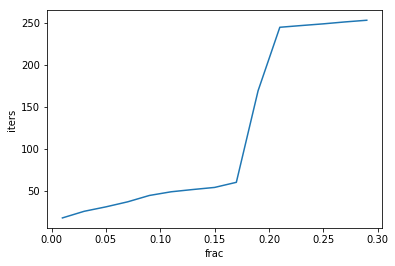

In [77]:
sns.lineplot(y='iters', x='frac', data=iterations_list_pos)

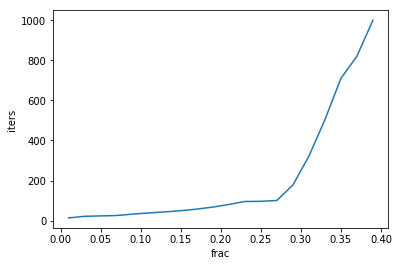

In [116]:
sns.lineplot(y='iters', x='frac', data=iterations_list_neg)

**Оценивание модели, вычисление ROC AUC and Gini coefficient**

##### Проделаем для стандартного метода, который уже использовался

    Берем множество объеков(тестовое)
    Для каждого объекта считаем множество положительных и негативных гипотез
    Разница между количеством гипотез будет как раз скором, а знак этой разницы - классом

In [339]:
for i, test_obg in test_sample[:1].iterrows():
    pos_hyps = mining_step(test_obj=test_obj, train_pos=train_pos, train_neg=train_neg, 
                            num_iters=600,sample_ratio=0.003, alpha = 0.004,
                                   hypothesis_criterion='contr_class', sample_type='random',
                                   mining_type='pos', trainx_min=trainx_min, trainx_max=trainx_max,
                                   classes_ratio=classes_ratio_pos, verbose=False, n_jobs=4
                        )

In [338]:
for i, test_obg in test_sample[:1].iterrows():
    neg_hyps = mining_step(test_obj=test_obj, train_pos=train_pos, train_neg=train_neg, 
                            num_iters=600,sample_ratio=0.003, alpha = 0.004,
                                   hypothesis_criterion='contr_class', sample_type='random',
                                   mining_type='neg', trainx_min=trainx_min, trainx_max=trainx_max,
                                   classes_ratio=classes_ratio_pos, verbose=False, n_jobs=2
                        )

In [291]:
pos_hyps = pd.DataFrame(pos_hyps)
neg_hyps = pd.DataFrame(neg_hyps)

In [295]:
from time import sleep

In [304]:
num_iters=600
sample_ratio=0.003
alpha = 0.004
hypothesis_criterion = 'contr_class'
sample_type = 'random'

In [303]:
def calculate_metric_for_obj(test_obj: pd.Series, train_pos: pd.DataFrame, train_neg: pd.DataFrame, 
                            num_iters, sample_ratio, alpha, hypothesis_criterion, sample_type,
                            trainx_min, trainx_max, classes_ratio_pos, classes_ratio_neg, verbose, n_jobs):
    
    
    pos_hyps = mining_step(test_obj=test_obj, train_pos=train_pos, train_neg=train_neg, 
                           num_iters=num_iters,sample_ratio=sample_ratio, alpha = alpha,
                           hypothesis_criterion=hypothesis_criterion, sample_type=sample_type,
                           mining_type='pos', trainx_min=trainx_min, trainx_max=trainx_max,
                           classes_ratio=classes_ratio_pos, verbose=verbose, n_jobs=n_jobs
                        )
    pos_hyps = pd.DataFrame(pos_hyps)
    
    sleep(10)
    
    neg_hyps = mining_step(test_obj=test_obj, train_pos=train_pos, train_neg=train_neg, 
                           num_iters=num_iters,sample_ratio=sample_ratio, alpha = alpha,
                           hypothesis_criterion=hypothesis_criterion, sample_type=sample_type,
                           mining_type='neg', trainx_min=trainx_min, trainx_max=trainx_max,
                           classes_ratio=classes_ratio_neg, verbose=verbose, n_jobs=n_jobs
                        )
    neg_hyps = pd.DataFrame(neg_hyps)
    
    sleep(5)
    
    diff = pos_hyps.shape[0] - neg_hyps.shape[0]
    label = None
    if diff > 0:
        label = 1
    elif diff < 0:
        label = 0
    else:
        label = -1
        
    return diff, label

In [302]:
def evaluate_model(test_sample: pd.DataFrame, train_pos, train_neg,  num_iters, sample_ratio,
                   alpha, hypothesis_criterion, sample_type, trainx_min, trainx_max,
                   classes_ratio_pos, classes_ratio_neg, verbose=False, n_jobs=2):
    
    results = {}
    
    print(f'using params: num_iters = {num_iters}, sample_ratio = {sample_ratio}, alpha = {alpha}')
    
    for i, test_obj in test_sample.iterrows():
        diff, label = calculate_metric_for_obj(test_obj=test_obj, train_pos=train_pos, train_neg=train_neg, 
                                num_iters=num_iters, sample_ratio=sample_ratio, alpha=alpha, 
                                hypothesis_criterion=hypothesis_criterion, sample_type=sample_type,
                                trainx_min=trainx_min, trainx_max=trainx_max,
                                 classes_ratio_pos=classes_ratio_pos, classes_ratio_neg=classes_ratio_neg, 
                                verbose=verbose, n_jobs=n_jobs)
        results[i] = (diff, label)
        
    return results


In [ ]:
results = {}

In [335]:
# %%time
# results = evaluate_model(test_sample=test_sample[8:9], train_pos=train_pos, train_neg=train_neg, 
#                          num_iters=1500, sample_ratio=sample_ratio, alpha=alpha, 
#                                 hypothesis_criterion=hypothesis_criterion, sample_type=sample_type,
#                                 trainx_min=trainx_min, trainx_max=trainx_max,
#                                  classes_ratio_pos=classes_ratio_pos, classes_ratio_neg=classes_ratio_neg, 
#                                 verbose=False, n_jobs=4)

In [336]:
# valY[test_sample[8:12].index]

In [337]:
# valY.sample(10)

In [24]:
# %%time
# t = hypothesises_to_feat_matrix(pos_hyps=pos_hyps, neg_hyps=neg_hyps, trainX=train_pos.sample(1))

**Обучение, основанное на признаках, полученных из сгенерированных гипотез**

In [276]:
def to_binary_repr(num: int, pos_hyps: pd.DataFrame, neg_hyps: pd.DataFrame, indices: list, trainX: pd.DataFrame):
    ind = indices[num]
    obj = trainX.loc[ind]
    pos_features = [f'pos_feat_{feat_num}' for feat_num in pos_hyps.index]
    neg_features = [f'neg_feat_{feat_num}' for feat_num in neg_hyps.index]
    features = pos_features + neg_features
    start_values = np.zeros(shape=(1, len(features)))
#     print(start_values.shape)
#     print(obj.name)
    result = pd.DataFrame(data=start_values,index=[obj.name], columns=features, dtype='int')
    ind = obj.name
    for pi in range(pos_hyps.shape[0]):
        feat_repr = utils.similarity(obj, pos_hyps.iloc[pi])
        is_included = pos_hyps.iloc[pi].equals(feat_repr)
        if is_included:
            result.loc[ind, f'pos_feat_{pi}'] = 1
        else:
            result.loc[ind, f'pos_feat_{pi}'] = 0
        
    for pi in range(neg_hyps.shape[0]):
        feat_repr = utils.similarity(obj, neg_hyps.iloc[pi])
        is_included = neg_hyps.iloc[pi].equals(feat_repr)
        if is_included:
            result.loc[ind, f'neg_feat_{pi}'] = 1
        else:
            result.loc[ind, f'neg_feat_{pi}'] = 0
                          
    return result

def transform_to_feature_matrix(pos_hyps: pd.DataFrame, neg_hyps: pd.DataFrame, trainX: pd.DataFrame, n_jobs: int = 4):
    
    indices = trainX.index
    transform_func = partial(to_binary_repr, pos_hyps=pos_hyps, 
                             neg_hyps=neg_hyps, indices=indices, trainX=trainX)
    
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        obj_features = executor.map(transform_func, range(len(indices)))

    features = pd.concat(obj_features)#pd.DataFrame(obj_features)
    
    return features

In [290]:
%%time
gen = transform_to_feature_matrix(pos_hyps=pos_hyps, neg_hyps=neg_hyps, trainX=trainX.sample(512))

CPU times: user 4.07 s, sys: 442 ms, total: 4.51 s
Wall time: 3min 47s


In [285]:
1.18, 1.25, 1.71, 2 range 1 4
3.95(8), 7.35(16), 29(64), 512

(1.18, 1.25, 1.71)

In [248]:
t.sum(axis=1)

28125    3
dtype: int64

In [140]:
def hypothesises_to_feat_matrix(pos_hyps: pd.DataFrame, neg_hyps: pd.DataFrame, trainX: pd.DataFrame):
    pos_features = [f'pos_feat_{feat_num}' for feat_num in pos_hyps.index]
#     neg_features = [f'neg_feat_{feat_num}' for feat_num in neg_hyps[pi]s.index]
    
    result = pd.DataFrame(index=trainX.index, columns=pos_features)# + neg_features)
    
    for i in range(trainX.shape[0]):
        for pi in range(pos_hyps.shape[0]):

            feat_repr = utils.similarity(obj, pos_hyps.iloc[pi])
            is_included = pos_hyps.iloc[pi].equals(feat_repr)
            if is_included:
                result.loc[i, f'pos_feat_{pi}'] = 1
            else:
                result.loc[i, f'pos_feat_{pi}'] = 0
                
        for pi in range(neg_hyps.shape[0]):
            feat_repr = utils.similarity(obj, neg_hyps.iloc[pi])
            is_included = neg_hyps.iloc[pi].equals(feat_repr)
            if is_included:
                result.loc[i, f'neg_feat_{pi}'] = 1
            else:
                result.loc[i, f'neg_feat_{pi}'] = 0
    
    
    return result
    

In [ ]:
###Данный вариант не прокатит, слишком долго
### Нужно придумать другой вариант

In [70]:
# %%time
# result = hypothesises_to_feat_matrix(pos_hyps=pos_hyps, neg_hyps=neg_hyps, trainX=trainX.sample(1000))

**Обучение композиции, основанное на гипотезах, считая их слабыми классификаторами(Бустинг)**

In [36]:
pos_hyps = pd.read_csv('hypothesises/test_pos_hyps.csv')
neg_hyps = pd.read_csv('hypothesises/test_neg_hyps.csv')
hyps = pd.concat([pos_hyps, neg_hyps])
hyps.reset_index(drop=True, inplace=True)

In [43]:
def hyps_boosting(hypothesises: pd.DataFrame, num_iterations):
    '''
    у гипотез есть индекс, просто число, от 0 до кол-ва гипотез, будем использовать его за id этой гипотезы
    '''
    
    ansamble = []
    weights = list(range(1, 11))
    weights = [w / 10 for w in weights]
    
    hyps_indices = list(hypothesises.index)
    
    ##допустим первую берем случайно(потом переделаем, чтоб брать осознанно)
    index = np.random.choice(hyps_indices, replace=False)
    h = hypothesises.loc[index]
    hyps_indices.remove(index)
    ansamble.append(h)
    
    #тут еще проверяется критерий того, что данный 
    while not hyps_indices and num_iterations > 0:
        
        index = np.random.choice(hyps_indices, replace=False)
        h = hypothesises.loc[index]
        
        
    
    return weights
    
    

In [42]:
hyps_boosting(hypothesises=hyps, num_iterations=10)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [83]:
inds = list(range(13))
inds

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [104]:
np.random.choice(inds)

5

In [62]:
# a = pd.Series({'feat1':(1,1), 'feat2':(0, 1.4), 'feat3':(3, 4)})
# b = pd.Series({'feat1':(1,2), 'feat2':(1, 1.4), 'feat3':(7, 7)})
# c = pd.Series({'feat1':(1,1), 'feat2':(0.8, 1.6), 'feat3':(3, 4)})
# d = pd.Series({'feat1':(2,3), 'feat2':(0, 1.4), 'feat3':(4, 6)})


# print(a.equals(b))
# print(a == b)

# test1 = pd.Series({'feat1':(1,3), 'feat2':(1, 3.4), 'feat3':(1, 1.9)})
# test2 = pd.Series({'feat1':(2,2.2), 'feat2':(2, 2.4), 'feat3':(3, 3.9)})
# test3 = pd.Series({'feat1':(3,3), 'feat2':(4, 4.4), 'feat3':(4, 4.9)})

g1 = pd.Series({'feat1':(1,1), 'feat2':(1.5, 1.5)})
g2 = pd.DataFrame({'feat1':(-1,-1), 'feat2':(0, 0)})
g3 = pd.Series({'feat1':(0.5,0.5), 'feat2':(1, 1)})

test1 = pd.Series({'feat1':(0.1, 1), 'feat2':(-0.5, 0)})
test2 = pd.DataFrame({'feat1':(-0.1, 1), 'feat2':(0.5, 0.8)})
tst = pd.Series({'feat1':(-1, 1), 'feat2':(0, 1.5)})

In [287]:
# for i,obj in sample.iterrows():
#     print(similarity(pd.DataFrame(d).T, obj))

In [286]:
# sample = pd.DataFrame([g1, g2, g3, test1, test2])
# sample

In [248]:
g1

feat1        (1, 1)
feat2    (1.5, 1.5)
dtype: object

In [95]:
type(d), type(sample)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [186]:
# is_included_in_repr(d, sample)

Тестовая функция провекри np.random.choice

In [40]:
def compute_stat(times, data):
    print(f"times = {times}")
    sample = np.random.RandomState().choice(data, replace=False, size=10)
    print(f"sample = {sample}")
    sample_sum = np.sum(sample)
    print(f"sample sum = {sample_sum}")
    return sample_sum

def run_computing(n_jobs=2):
    data = list(range(100))
    
    compute_func = partial(compute_stat, data=data)
    
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        results = executor.map(compute_func, list(range(26)))
    
    return results

In [284]:
# t = run_computing(n_jobs=6)